# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.TransferCFM import StandardCFM as TransferCFM
from memflow.ttH.models.Transfusion import StandardCFM as Transfusion
from memflow.ttH.models.ParallelTransfusion import StandardCFM as ParallelTransfusion
from memflow.ttH.models.TransferCFM_original import StandardCFM as OriginalCFM

from memflow.ttH.distribution_plots import *
from models.utils import load_samples, save_samples, move_batch_to_device

from transfer_flow.transfer_flow_model import *
from transfer_flow.custom_flows import *

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-03-16 13:36:38.757096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 13:36:38.757142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 13:36:38.757170: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn  

# Reco dataset

In [4]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [5]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt

# Combined dataset

In [6]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs   

In [7]:
TransferCFM_model = TransferCFM.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/TransferCFM_checkpoints/model_epoch_500.ckpt")
TransferCFM_model.to(accelerator)
TransferCFM_model.eval()

No hard attention mask provided; will use existence mask only.


/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fea

In [8]:
ParallelTransfusion_model = ParallelTransfusion.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/parallel_transfusion_checkpoints/model_epoch_500.ckpt")
ParallelTransfusion_model.to(accelerator)
ParallelTransfusion_model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64
('pt', 'eta', 'phi', 'mass')
('pt', 'phi')


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

In [ ]:
transfermer_model = TransferFlow.load_from_checkpoint(
    checkpoint_path="trained_model_checkpoints/TransferFlow_checkpoints/model_epoch_500.ckpt",
    encoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.hard_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    decoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.reco_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    transformer=Transformer(
        d_model=64,
        encoder_layers=6,
        decoder_layers=8,
        nhead=8,
        dim_feedforward=256,
        activation=nn.GELU,
        encoder_mask_attn=None,
        decoder_mask_attn=combined_dataset.reco_dataset.attention_mask,
        use_null_token=True,
        dropout=0.0,
    ),
    flow=KinematicFlow(
        d_model=64,
        flow_mode='global',
        flow_features=[
            ['pt', 'eta', 'phi', 'mass'],  # jets
            ['pt', 'phi'],  # met
        ],
        flow_classes={
            'pt': zuko.flows.NSF,
            'eta': UniformNSF,
            'phi': UniformNCSF,
            'mass': zuko.flows.NSF,
        },
        flow_common_args={
            'bins': 16,
            'transforms': 5,
            'randperm': True,
            'passes': None,
            'hidden_features': [256] * 3,
        },
        flow_specific_args={
            'eta': {'bound': 1.0},
            'phi': {'bound': math.pi},
        },
    ),
)
transfermer_model.to(accelerator)
transfermer_model.eval()

### Load in the full transfermer samples

In [ ]:
transfermer_samples_full_file = "Transfermer_samples_full.pt"

if os.path.exists(os.path.join("saved_samples", transfermer_samples_full_file)):
    transfermer_samples_full = load_samples(transfermer_samples_full_file)
else:
    # Split dataset into training and validation (using 80% training)
    train_frac = 0.8
    indices = torch.arange(len(combined_dataset))
    sep = int(train_frac * len(combined_dataset))
    valid_indices = indices[sep:]
    combined_dataset_valid = torch.utils.data.Subset(combined_dataset, valid_indices)
    print(f'Dataset : validation {len(combined_dataset_valid)}')

    # Set up a DataLoader for the validation set (batch_size can be adjusted)
    full_loader = DataLoader(
        combined_dataset_valid,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # List to store samples from each mini-batch
    transfermer_samples_full_list = []

    # Loop over the validation batches without tracking gradients
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset for Transfermer model")):

            # Transfer batch to the appropriate device using the model's method
            batch = transfermer_model.transfer_batch_to_device(batch, transfermer_model.device, batch_idx)

            # Sample using the Transfer Flow model; note we do not use a 'steps' argument here.
            transfermer_samples_full = transfermer_model.sample(
                batch['hard']['data'],
                batch['hard']['mask'],
                batch['reco']['data'],
                batch['reco']['mask'],
                N=100  # number of samples per event
            )

            # Permute each tensor so that the output shape is [batch, N_sample, particles, features]
            transfermer_samples_full = [sample.cpu() for sample in transfermer_samples_full]

            # Feature indices to keep
            jets_indices = [0, 1, 2, 3]  # Keep ['pt', 'eta', 'phi', 'mass'], remove index 4 ('btag')
            met_indices = [0, 2]         # Keep ['pt', 'phi'], remove indices 1 ('eta') and 3 ('mass')

            # Apply feature selection
            transfermer_samples_full[0] = transfermer_samples_full[0][..., jets_indices]  # Filter jet features
            transfermer_samples_full[1] = transfermer_samples_full[1][..., met_indices]   # Filter MET features

            transfermer_samples_full_list.append(transfermer_samples_full)

    # Concatenate corresponding tensors from all batches along the batch dimension
    num_items = len(transfermer_samples_full_list[0])
    transfermer_samples_full = [
        torch.cat([batch_output[i] for batch_output in transfermer_samples_full_list], dim=1)
        for i in range(num_items)
    ]

    # Debugging prints
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(transfermer_samples_full):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated samples for later plotting/comparison
    save_samples(transfermer_samples_full, transfermer_samples_full_file)

# 10mins 25s for 100 samples 18364 events


### Load in the full Parallel Transfusion samples

In [ ]:
PT_samples_full_file = "PT_samples_full.pt"

if os.path.exists(os.path.join("saved_samples", PT_samples_full_file)):
    PT_samples_full = load_samples(PT_samples_full_file)
else:
    train_frac = 0.8
    indices = torch.arange(len(combined_dataset))
    sep = int(train_frac*len(combined_dataset))
    valid_indices = indices[sep:]
    combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
    print (f'Dataset : validation {len(combined_dataset_valid)}')

    # Use a DataLoader with batch_size=10 for testing (change as needed)
    full_loader = DataLoader(
        combined_dataset_valid,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Lists to accumulate outputs from each mini-batch
    PT_samples_full_list = []

    with torch.no_grad():
        # Use enumerate to get the batch index along with the batch
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset")):

            # Move the batch to the appropriate device
            batch = move_batch_to_device(batch, ParallelTransfusion_model.device)

            # Extract inputs for the sampling function
            hard_data = batch["hard"]["data"]
            hard_mask = batch["hard"]["mask"]
            reco_data = batch["reco"]["data"]
            reco_mask = batch["reco"]["mask"]

            # Run model sampling on the current batch
            PT_samples_full = ParallelTransfusion_model.sample(
                hard_data,
                hard_mask,
                reco_data,
                reco_mask,
                N_sample=100,      # number of samples per event
                steps=20,
            )

            # Append outputs from this batch (each is a list of tensors)
            PT_samples_full_list.append(PT_samples_full)

    # Determine the number of elements per sample (assuming it's consistent across batches)
    num_items = len(PT_samples_full_list[0])

    # Concatenate corresponding elements across batches along the batch dimension (dim=2)
    PT_samples_full = [
        torch.cat([batch_output[i] for batch_output in PT_samples_full_list], dim=1)
        for i in range(num_items)
    ]

    # Debugging prints
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(PT_samples_full):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated results
    save_samples(PT_samples_full, PT_samples_full_file)

# 88mins 23s for 100 samples 18364 events 

### Load in the full Transfer-CFM samples

In [ ]:
TransferCFM_samples_full_file = "TransferCFM_samples_full.pt"

if os.path.exists(os.path.join("saved_samples", TransferCFM_samples_full_file)):
    TransferCFM_samples_full = load_samples(TransferCFM_samples_full_file)
else:
    train_frac = 0.8
    indices = torch.arange(len(combined_dataset))
    sep = int(train_frac*len(combined_dataset))
    valid_indices = indices[sep:]
    combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
    print (f'Dataset : validation {len(combined_dataset_valid)}')

    # Use a DataLoader with batch_size=10 for testing (change as needed)
    full_loader = DataLoader(
        combined_dataset_valid,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Lists to accumulate outputs from each mini-batch
    TransferCFM_samples_full_list = []

    with torch.no_grad():
        # Use enumerate to get the batch index along with the batch
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset")):

            # Move the batch to the appropriate device
            batch = move_batch_to_device(batch, TransferCFM_model.device)

            # Extract inputs for the sampling function
            hard_data = batch["hard"]["data"]
            hard_mask = batch["hard"]["mask"]
            reco_data = batch["reco"]["data"]
            reco_mask = batch["reco"]["mask"]

            # Run model sampling on the current batch
            TransferCFM_samples_full = TransferCFM_model.sample(
                hard_data,
                hard_mask,
                reco_data,
                reco_mask,
                N_sample=100,      # number of samples per event
                steps=20,
            )

            # Append outputs from this batch (each is a list of tensors)
            TransferCFM_samples_full_list.append(TransferCFM_samples_full)

    # Determine the number of elements per sample (assuming it's consistent across batches)
    num_items = len(TransferCFM_samples_full_list[0])

    # Concatenate corresponding elements across batches along the batch dimension (dim=2)
    TransferCFM_samples_full = [
        torch.cat([batch_output[i] for batch_output in TransferCFM_samples_full_list], dim=1)
        for i in range(num_items)
    ]

    # Debugging prints
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(TransferCFM_samples_full):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated results
    save_samples(TransferCFM_samples_full, TransferCFM_samples_full_file)

# 26min 24s for 100 samples, 18364 events

In [ ]:
gen_data1 = transfermer_samples_full
gen_data2 = PT_samples_full
gen_data3 = TransferCFM_samples_full

Now load in the real reco-level data to compare the models to. Be careful, this has to match the events the model were sampled from

In [ ]:
train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
valid_indices = indices[sep:]
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : validation {len(combined_dataset_valid)}')

# Use a DataLoader with batch_size=10 for testing (change as needed)
loader = DataLoader(
    combined_dataset_valid,
    batch_size=20000,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
batch = next(iter(loader))
batch = move_batch_to_device(batch, TransferCFM_model.device)
print(f'Number of batches: {len(loader)}')
print(f"batch_size: {len(batch['hard']['data'][0])}")
# Get the reco mask for the same index.
real_data = batch["reco"]["data"]
real_mask = batch["reco"]["mask"]

In [ ]:
fd = FeatureDistributions(TransferCFM_model, preprocessing=combined_dataset.reco_dataset.preprocessing, real_mask=real_mask)
fd.compare_distributions(real_data, gen_data1, ptype_idx=0, feat_idx=0, nbins=500, feat_name="pT")
# MET
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=1, feat_idx=0, nbins=500, feat_name=r'$p_T$ [GeV]')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=1, feat_idx=1, nbins=50, feat_name=r'$\phi$ [rad]')
# Jets
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=0, feat_idx=0, nbins=1000, feat_name=r'$p_T$ [GeV]')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=0, feat_idx=1, nbins=50, feat_name=r'$\eta$')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=0, feat_idx=2, nbins=50, feat_name=r'$\phi$ [rad]')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, gen_data3, ptype_idx=0, feat_idx=3, nbins=400, feat_name=r'Mass [GeV]')

In [ ]:
# Define feature index mapping (for jets)
feat_idx_map = {"pt": 0, "eta": 1, "phi": 2, "mass": 3}

# Initialize the HighLevelDistributionsVector class
high_level_dists = HighLevelDistributions(
    model = ParallelTransfusion_model,
    preprocessing = combined_dataset.reco_dataset.preprocessing,
    feat_idx_map = feat_idx_map,
    real_data = real_data,
    real_mask = real_mask,
    gen_data = gen_data1,
    gen_data2 = gen_data2,
    gen_data3 = gen_data3,
    jet_ordering = "btag"  # Change to "pt" if you want to reorder all jets by pT
)


# Now you can plot individual observables:
high_level_dists.plot_E_j1()
high_level_dists.plot_pT_j1()
high_level_dists.plot_dphi_j1j2()   # Uses built-in .deltaphi
high_level_dists.plot_dR_j1j2()     # Uses built-in .deltaR
high_level_dists.plot_HT()          # Scalar sum of pT
high_level_dists.plot_dR_met_jj()   # Uses vector sum of MET + dijet
high_level_dists.plot_min_mass_jj() # Uses invariant mass calculation

# # Or plot all distributions in one go:
# high_level_dists.plot_all()


# Trajectories Plots

Load in the original CFM model

In [9]:
model = OriginalCFM.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/originalCFM/model_epoch_500.ckpt")
model.to(accelerator)
model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

Now get the trajectories data by either:
- Evaluating the Original CFM model and saving the intermediate trajectories during sampling
- Load in the data if it already exists

In [10]:
trajectories_loader = DataLoader(
    combined_dataset,
    batch_size = 10000,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)

batch = next(iter(trajectories_loader))
batch = move_batch_to_device(batch, model.device)

# Print the structure of the batch
print("Batch structure:")
for key in batch:
    print(f"{key}:")
    for sub_key, val in batch[key].items():
        if isinstance(val, list):
            print(f"  {sub_key}: {[v.shape for v in val]}")
        elif isinstance(val, torch.Tensor):
            print(f"  {sub_key}: {val.shape}")

traj_samples_file = "traj_samples.pt"
all_traj_file = "all_traj.pt"
if os.path.exists(os.path.join("saved_samples", traj_samples_file)) and os.path.exists(os.path.join("saved_samples", all_traj_file)):
    traj_samples = load_samples(traj_samples_file)
    all_traj = load_samples(all_traj_file)
else:
    with torch.no_grad():
        model = model.to(model.device)

        # Extract the necessary inputs for sampling
        hard_data = batch["hard"]["data"]
        hard_mask = batch["hard"]["mask"]
        reco_data = batch["reco"]["data"]
        reco_mask = batch["reco"]["mask"]

        print(f"Hard data batch size: {hard_data[0].shape[0]}")
        print(f"Reco data batch size: {reco_data[0].shape[0]}")

        traj_samples, all_traj = model.sample(
            hard_data,
            hard_mask,
            reco_data,
            reco_mask,
            N_sample=1000,
            steps=20,
            store_trajectories=True
        )
    save_samples(traj_samples, traj_samples_file)
    save_samples(all_traj, all_traj_file)
    # Took 12 mins for 100 samples

Batch structure:
hard:
  data: [torch.Size([10000, 2, 5]), torch.Size([10000, 4, 5]), torch.Size([10000, 4, 5])]
  mask: [torch.Size([10000, 2]), torch.Size([10000, 4]), torch.Size([10000, 4])]
  weights: [torch.Size([10000, 2]), torch.Size([10000, 4]), torch.Size([10000, 4])]
reco:
  data: [torch.Size([10000, 6, 5]), torch.Size([10000, 1, 4])]
  mask: [torch.Size([10000, 6]), torch.Size([10000, 1])]
  weights: [torch.Size([10000, 6]), torch.Size([10000, 1])]
Samples loaded from saved_samples/traj_samples.pt
Samples loaded from saved_samples/all_traj.pt


Create the trajectories plots:
 1. Choose the first sample for an event and plot for multiple events
 2. Choose a single event and object, plot the trajectories for all the samples
 3. Grid plot showing the velocity field

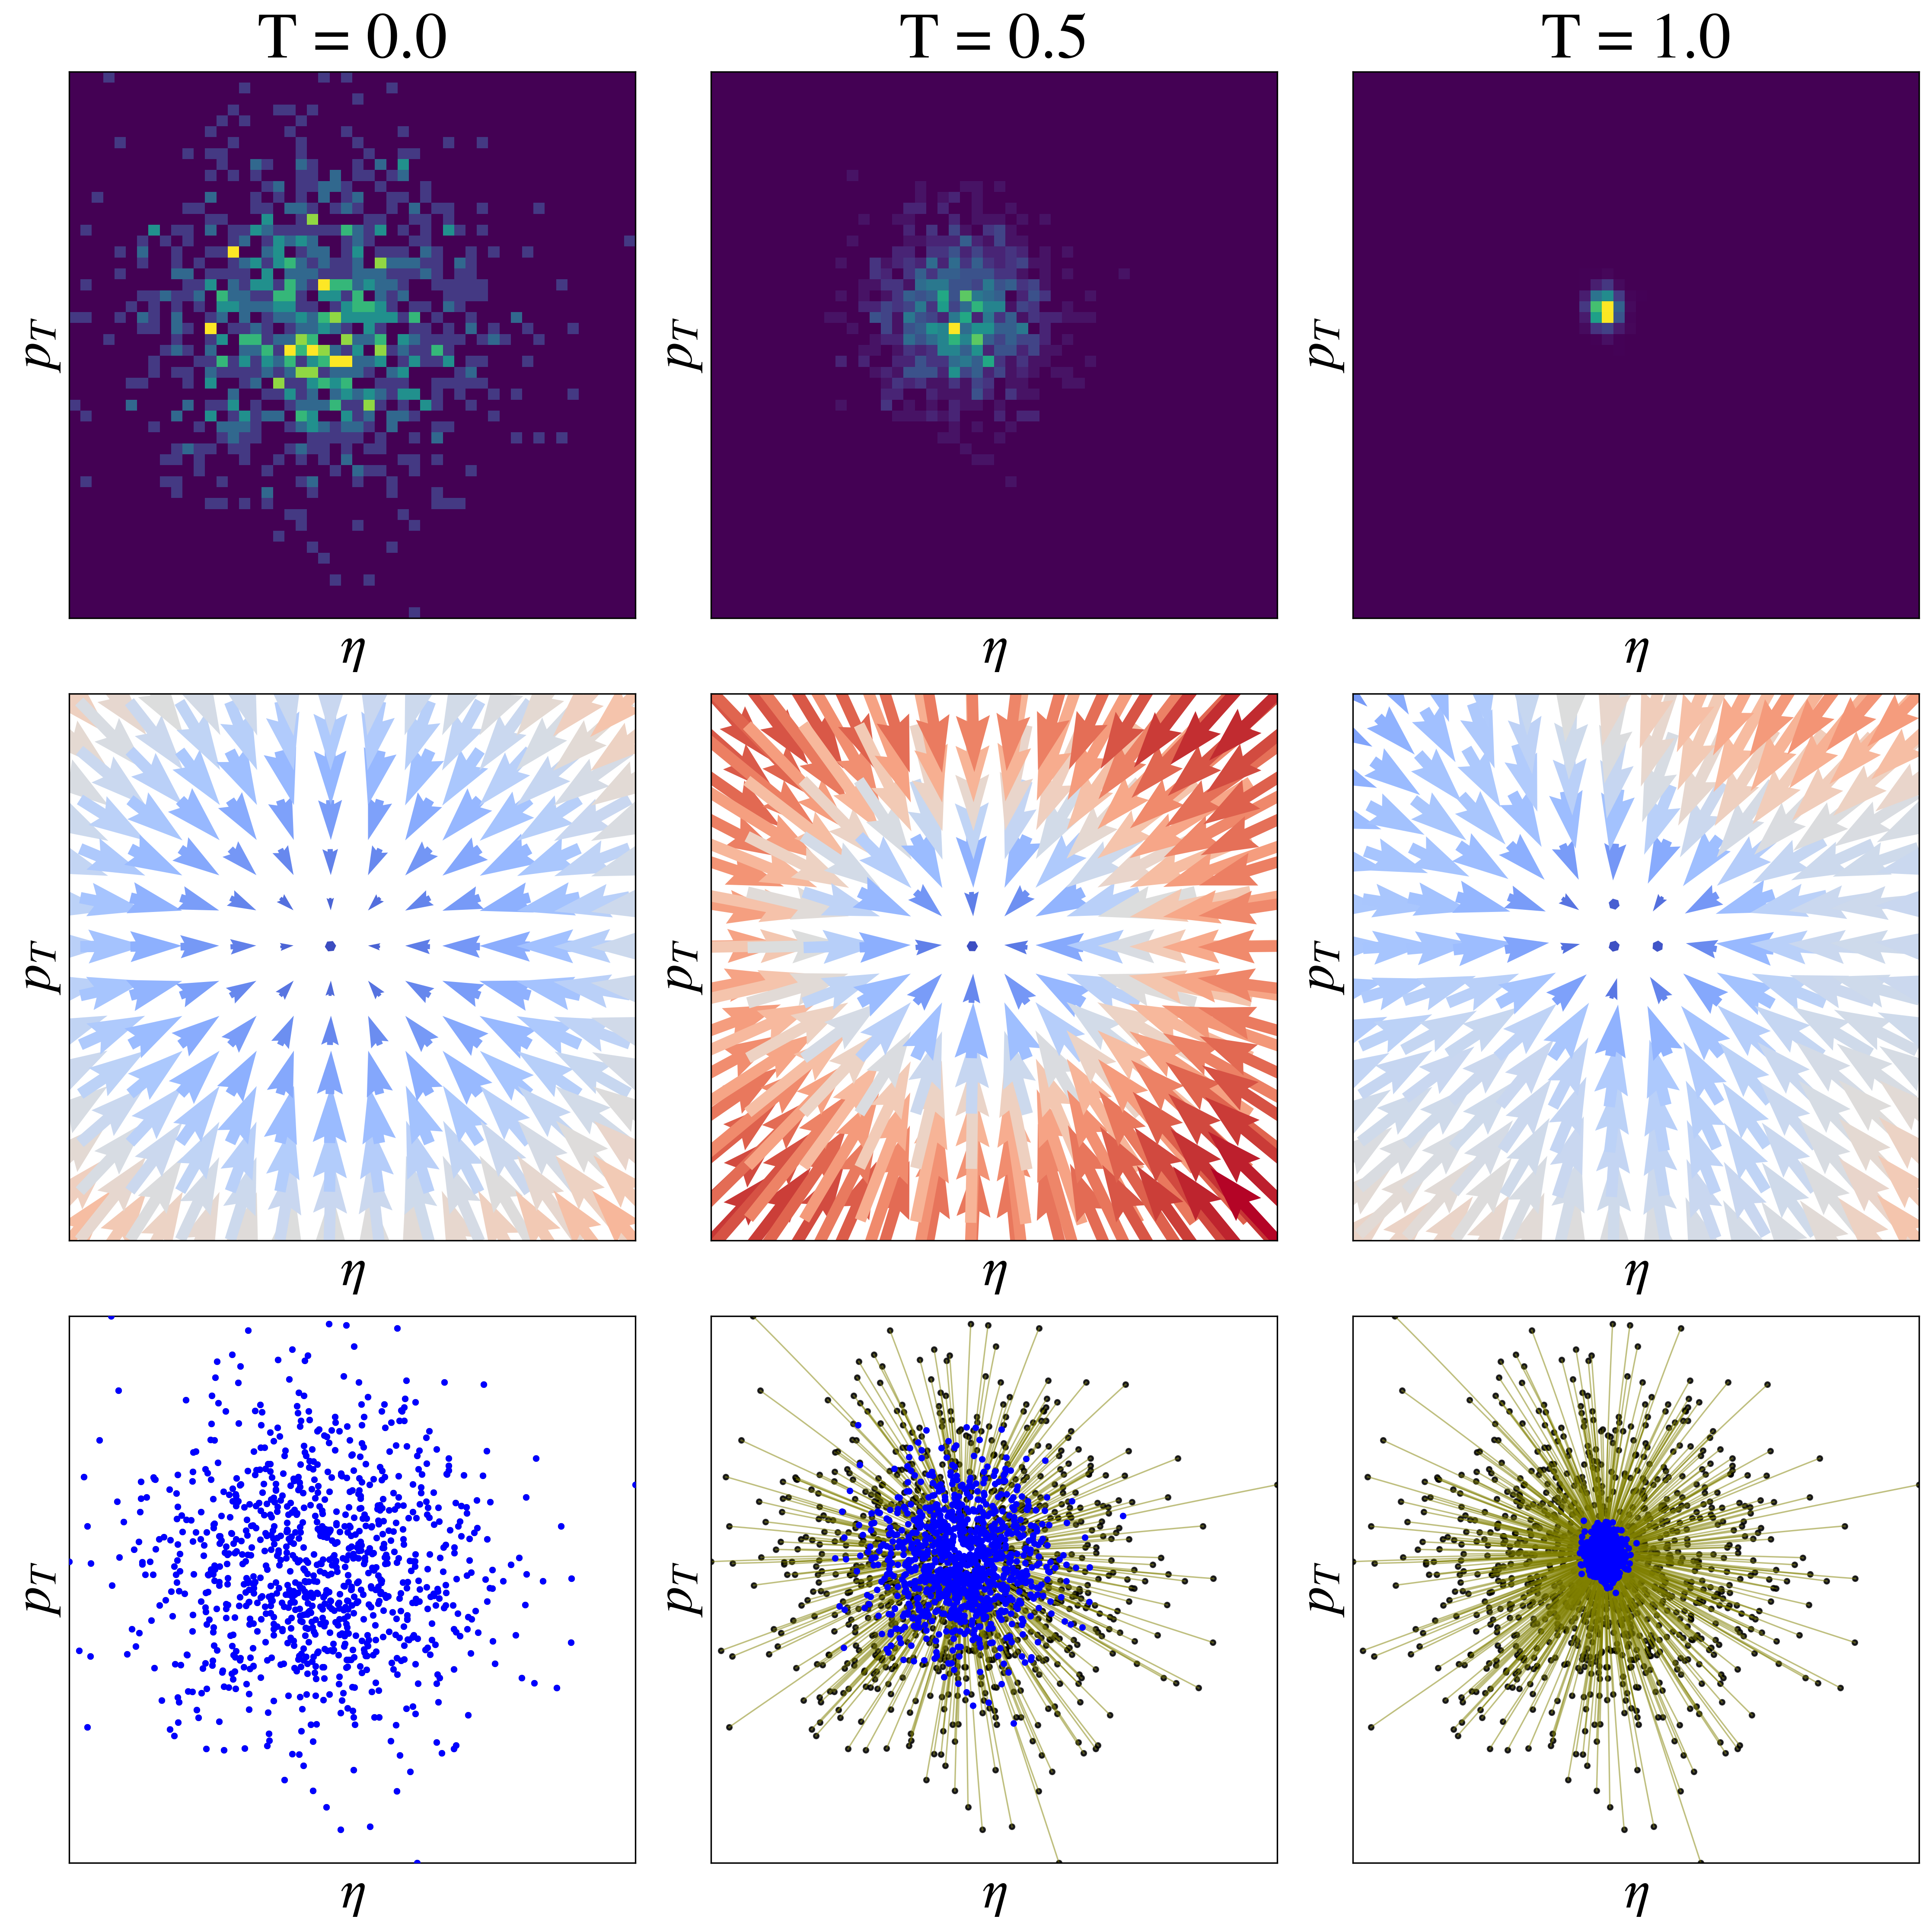

In [15]:
traj_plots = TrajectoriesPlots(model)
# Plot a 2D scatter of trajectories.
# Here, type_idx=0 might correspond to jets.
# We plot feature 0 vs feature 1 (for example, pT vs. φ) and show trajectories for up to 5 events.
# traj_plots.plot_trajectories_2d(
#     all_traj=all_traj,
#     type_idx=0,
#     feat_idx_x=0,
#     feat_idx_y=1,
#     num_events=5,  # number of events to plot
#     mode="multiple_events",
#     batch=batch
# )

# # Alternatively, you can plot trajectories for a single event:
# # (Here event_idx=0, object_idx=0 correspond to the first event and the first particle in that type.)
# traj_plots.plot_trajectories_2d(
#     all_traj=all_traj,
#     type_idx=1,
#     feat_idx_x=1,
#     feat_idx_y=0,
#     event_idx=1,
#     object_idx=0,
#     mode="single_event",
#     batch=batch
# )

# Plot a grid of density, velocity field, and trajectories at custom timesteps.
# custom_timesteps is a list of integration step indices (e.g., [0, 5, 10, 15, 20])
traj_plots.plot_trajectories_grid(
    all_traj=all_traj,
    custom_timesteps=[0, 10, 20],
    type_idx=0,
    feat_idx_x=1,
    feat_idx_y=0,
    event_idx=57,    # choose the event to display
    object_idx=0,   # choose the object (particle) index within that type
    grid_size=14,    # resolution for the vector field grid
    batch=batch
)